In [1]:
import pandas as pd
from sklearn.cluster import Ward
import matplotlib.pyplot as plt
import numpy as np
from pandas import merge
from sklearn.decomposition import PCA
from __future__ import division
from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix

Org_Level = 'Org Level 3'

df = pd.read_csv('C:\Users\KpanForRealz\Desktop\UCSF Intern\DataFile.csv',
                parse_dates = ['Transaction Date'],
                thousands=',')

supplier_filter = '|'.join(['FISHER SCIENTIFIC',
                            'VWR',
                            'SIGMA ALDRICH',
                            'BIOEXPRESS',
                            'LIFE TECHNOLOGIES CORP',
                            'USA SCIENTIFIC',
                            'DENVILLE',
                            'CLONTECH',
                            'GE HEALTHCARE BIO',
                            'NEW ENGLAND BIO',
                            'SPECTRUM CHEMICAL', 
                            'SPECTRUM LABORATORY',
                            'PROMEGA'
                            ])

df_filtered = df[df['Supplier Normalized Name'].str.contains(supplier_filter) & (df['Spend'] > 0)]

N_Suppliers = df_filtered['Supplier Normalized Name'].nunique()

In [2]:
#Create a set of features for the total spend per supplier per department
Spend_per_Supplier = pd.pivot_table(df_filtered, values='Spend', index=['Campus', Org_Level], 
                                 columns='Supplier Normalized Name', aggfunc=np.sum, fill_value=0)

#Create the Invoice Per PO feature
PO_by_Inv = pd.pivot_table(df_filtered, index=['Campus',Org_Level], values=['# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0)
cutoff = 20
#Replace # of PO = 0 with a .01 so that we can avoid INF errors
PO_by_Inv.replace(0,1,True)
#Divide
PO_by_Inv['Inv/PO'] = (PO_by_Inv['# of Invoices']/PO_by_Inv['# of POs'])
#Take care of inf
PO_by_Inv['Inv/PO'].replace('inf',cutoff,True)
#Drop unnecessary columns
PO_by_Inv = PO_by_Inv.drop(['# of Invoices','# of POs'],1)
#Filter out the outliers and change them to a "cutoff"
PO_by_Inv['Inv/PO'][PO_by_Inv['Inv/PO'] > cutoff] = cutoff
Log_PO_by_Inv = pd.DataFrame(np.log(PO_by_Inv))

#Create the supplier count feature
Count_Supplier= DataFrame(pd.pivot_table(df_filtered, index=['Campus',Org_Level],values='Supplier Normalized Name',aggfunc=lambda x: len(x.unique())))
Count_Supplier = Count_Supplier.rename(columns={'Supplier Normalized Name':'Count of Suppliers'})

#Create the Spend Diffusion Metric
Max_Supplier_Spend = pd.pivot_table(df_filtered, index=['Campus',Org_Level,'Supplier Normalized Name'], 
                                          values=['Spend'], aggfunc=np.max, fill_value=0).reset_index().groupby(['Campus',Org_Level]).max().drop(['Supplier Normalized Name'],1)
Total_Dept_Spend = pd.pivot_table(df_filtered, index=['Campus',Org_Level], values=['Spend'], aggfunc=np.sum, fill_value=0)
Spend_Diffusion = 1-(Max_Supplier_Spend/Total_Dept_Spend)
Spend_Diffusion = Spend_Diffusion.rename(columns={'Spend':'Spend_Diffusion'})
Log_Spend_Diffusion = pd.DataFrame(np.log(Spend_Diffusion))

#Create Spend Frequency and Average Monthly Spend/PO/Invoice Features
Dept_Summary = pd.pivot_table(df_filtered, index=['Campus',Org_Level], values=['Spend','# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0).reset_index()
#pivot out by campus, department, and date then find the summary stats of the time based dimensions
#Create a frame that is grouped by month and sum of all values
dept_time = pd.pivot_table(df_filtered, index=['Campus',Org_Level,'Transaction Date' ], values=['Spend','# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0).reset_index()
dept_time = dept_time.groupby(['Campus',Org_Level,dept_time['Transaction Date'].map(lambda x: (x.month,x.year))]).sum().reset_index()
avg_monthly = pd.DataFrame(dept_time.groupby(['Campus',Org_Level]).mean()['Spend'])
Count_Months = pd.DataFrame(dept_time.groupby(['Campus',Org_Level]).count()['Transaction Date'])

#Merge all the features into the Department_Analysis Frame (Un-comment to run these)
Department_Analysis = pd.merge(Spend_per_Supplier,PO_by_Inv,left_index=True, right_index=True,how='left')
Department_Analysis = pd.merge(Department_Analysis,Count_Supplier,left_index=True, right_index=True,how='left')
Department_Analysis = pd.merge(Department_Analysis,Spend_Diffusion,left_index=True, right_index=True,how='left').fillna(0)
Department_Analysis = pd.merge(Department_Analysis,Count_Months,left_index=True, right_index=True,how='left').fillna(0)
Department_Analysis = pd.merge(Department_Analysis,Log_PO_by_Inv,left_index=True, right_index=True,how='left').fillna(0)
Department_Analysis = pd.merge(Department_Analysis,avg_monthly,left_index=True, right_index=True,how='left').fillna(0)

#For some reason 1/Department_Analysis['Count of Suppliers'] didn't work so I created column of all 1
Department_Analysis['one']=1
Department_Analysis['Optimal Diffusion']= Department_Analysis['one']-(Department_Analysis['one']/Department_Analysis['Count of Suppliers'])
Department_Analysis['% Opt-Actual']=(Department_Analysis['Optimal Diffusion']-Department_Analysis['Spend_Diffusion'])/Department_Analysis['Optimal Diffusion']
Department_Analysis['% Opt-Actual']=Department_Analysis['% Opt-Actual'].fillna(0)
Department_Analysis[Department_Analysis['Spend_Diffusion']== -np.inf] = 0
Department_Analysis[Department_Analysis['% Opt-Actual']== -np.inf] = 0


del Department_Analysis['one']
del Department_Analysis['Optimal Diffusion']

#Calculate the number of non-Supplier Spend dimensions
NonSupplier_Features = len(Department_Analysis.columns) - N_Suppliers

In [4]:
NonSupplier_Features
Department_Analysis

Supplier Normalized Name               BIOEXPRESS LLC  CLONTECH LABS INC  \
Campus Org Level 3                                                         
UCB    Academic Research Units                1565.31           82240.65   
       Academic Senate                           0.00               0.00   
       Administration & Finance                  0.00               0.00   
       Art Mus & Pacific Film Archive            0.00               0.00   
       Boalt School of Law                       0.00               0.00   
       Cal Performances_SMA                      0.00               0.00   
       Campus Support Core                       0.00               0.00   
       Col of Environmental Design               0.00               0.00   
       College of Chemistry                    117.80            2304.15   
       College of Engineering                    0.00             641.70   
       College of Natural Resources           6171.71           18751.03   
       Equity & Inclusion Div                    0.00               0.00   
       Facilities Services                       0.00               0.00   
       Goldman Sch of Public Policy              0.00               0.00   
       Graduate School of Education              0.00               0.00   
       Haas School of Business                   0.00               0.00   
       L&S Arts & Humanities                     0.00               0.00   
       L&S Biological Sciences               60335.46           47148.12   
       L&S Math & Physical Sci                   0.00               0.00   
       L&S Social Sciences                       0.00               0.00   
       Real Estate                               0.00               0.00   
       Res Museum & Field Stations             691.23               0.00   
       Research Administrative Units             0.00               0.00   
       School of Journalism                      0.00               0.00   
       School of Optometry                    2681.71             141.39   
       School of Public Health                   0.00            3531.41   
       School of Social Welfare                  0.00               0.00   
       Strategic Acad and Fac Plan               0.00               0.00   
       Student Affairs                         298.94               0.00   
       Summer Sessn, Study Abrd, OLLI            0.00               0.00   
...                                               ...                ...   
UCSF   M_Neurological Surgery                18357.87           14936.00   
       M_Neurology                             720.32           14453.37   
       M_ObGyn, Reproductive Sciences          382.32            1419.43   
       M_Ophthalmology                           0.00            1765.83   
       M_Orthopaedic Surgery                     0.00             516.88   
       M_Osher Center                            0.00               0.00   
       M_Otolaryngology                          0.00            2957.10   
       M_PEDIATRICS                              0.00            6496.39   
       M_Pathology                             601.80            4916.00   
       M_Physical Therapy                        0.00               0.00   
       M_Physiology                           5035.19            6738.45   
       M_Psychiatry                            366.23           12810.02   
       M_Radiation Oncology                      0.00            1370.89   
       M_Radiology                               0.00               0.00   
       M_Regeneration Medicine                   0.00           45533.20   
       M_School Level Holding                    0.00               0.00   
       M_Surgery                              1036.91             266.34   
       M_Urology                               715.37            5571.86   
       N_Community Health Systems                0.00               0.00   
       N_Dean's Office                          

C:\Users\KpanForRealz\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


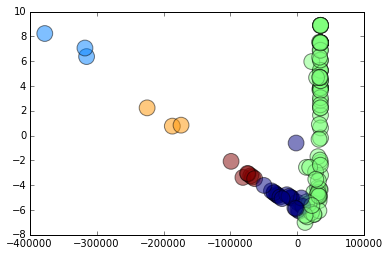

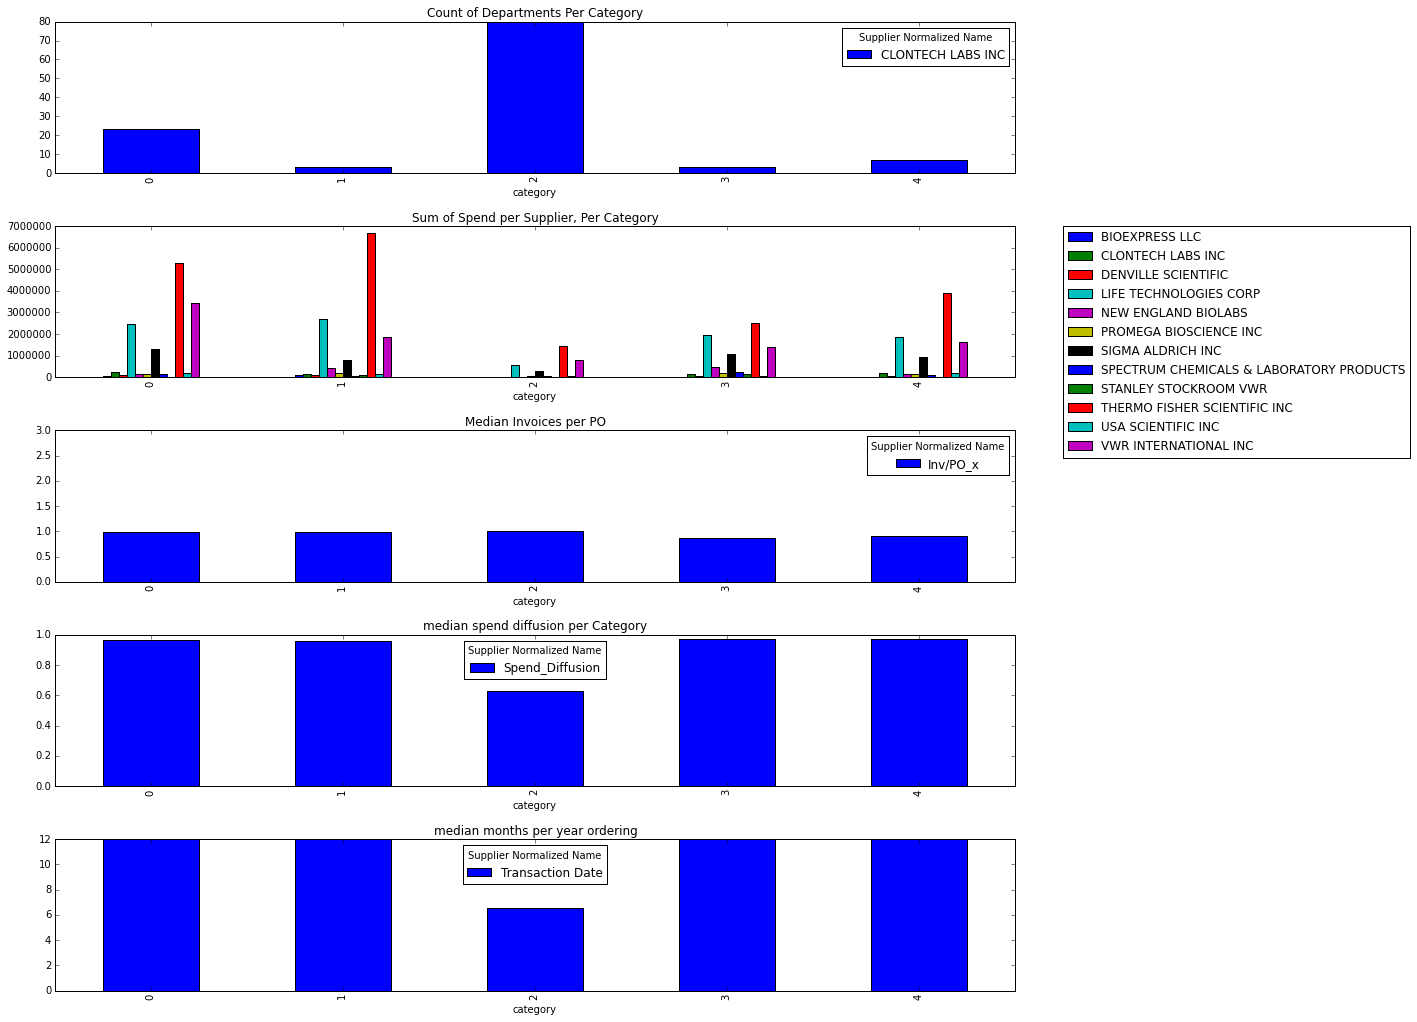

In [3]:
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

#Drop the category column if it exists
for col in Department_Analysis.columns:
    if col is 'category':
        Department_Analysis = Department_Analysis.drop(col,1)
        
        
#Use PCA to reduce dimensionality to 2 to check the variance explained and inspect the clusters
pca = PCA(n_components=3).fit_transform(Department_Analysis.ix[:,-NonSupplier_Features:])
pcaT = PCA(n_components=3).fit(Department_Analysis.ix[:,-NonSupplier_Features:])


#Run the heirarchical clustering
agglomerativeClustering = AgglomerativeClustering(n_clusters=5)
Department_Analysis['category'] = agglomerativeClustering.fit_predict(Department_Analysis.ix[:,-NonSupplier_Features:])

#Run PCA and chart the two leading Components to see what the clusters look like in 2D space
sc = plt.scatter(pca[:,0],pca[:,1], s=250, c=Department_Analysis.category, alpha=0.5, edgecolors='black')
plt.legend()
plt.show()

#Group the data by supplier and plot it to see the spend per supplier/per cluster.
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(14, 14))
fig.tight_layout()
fig.subplots_adjust(hspace=.35)
ax1 = Department_Analysis.groupby('category').count()[[1]].plot(kind='bar',ax=axes[0], title='Count of Departments Per Category', label=None)
ax2 = Department_Analysis.groupby('category').sum()[[x for x in Department_Analysis.columns[0:N_Suppliers]]].plot(kind='bar',ax=axes[1], title='Sum of Spend per Supplier, Per Category').legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax3 = Department_Analysis.groupby('category').median()[['Inv/PO_x']].plot(kind='bar',ax=axes[2], title='Median Invoices per PO')
ax3.set_ylim(0,3)
ax4 = Department_Analysis.groupby('category').median()[['Spend_Diffusion']].plot(kind='bar',ax=axes[3], title='median spend diffusion per Category')
ax4.set_ylim(0,1)
ax5 = Department_Analysis.groupby('category').mean()[['Transaction Date']].plot(kind='bar',ax=axes[4], title='median months per year ordering')

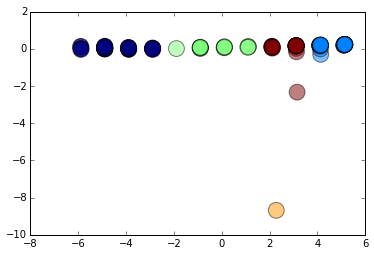

In [28]:
#Ward first try

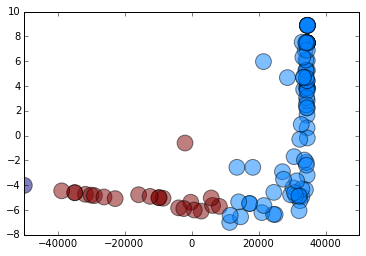

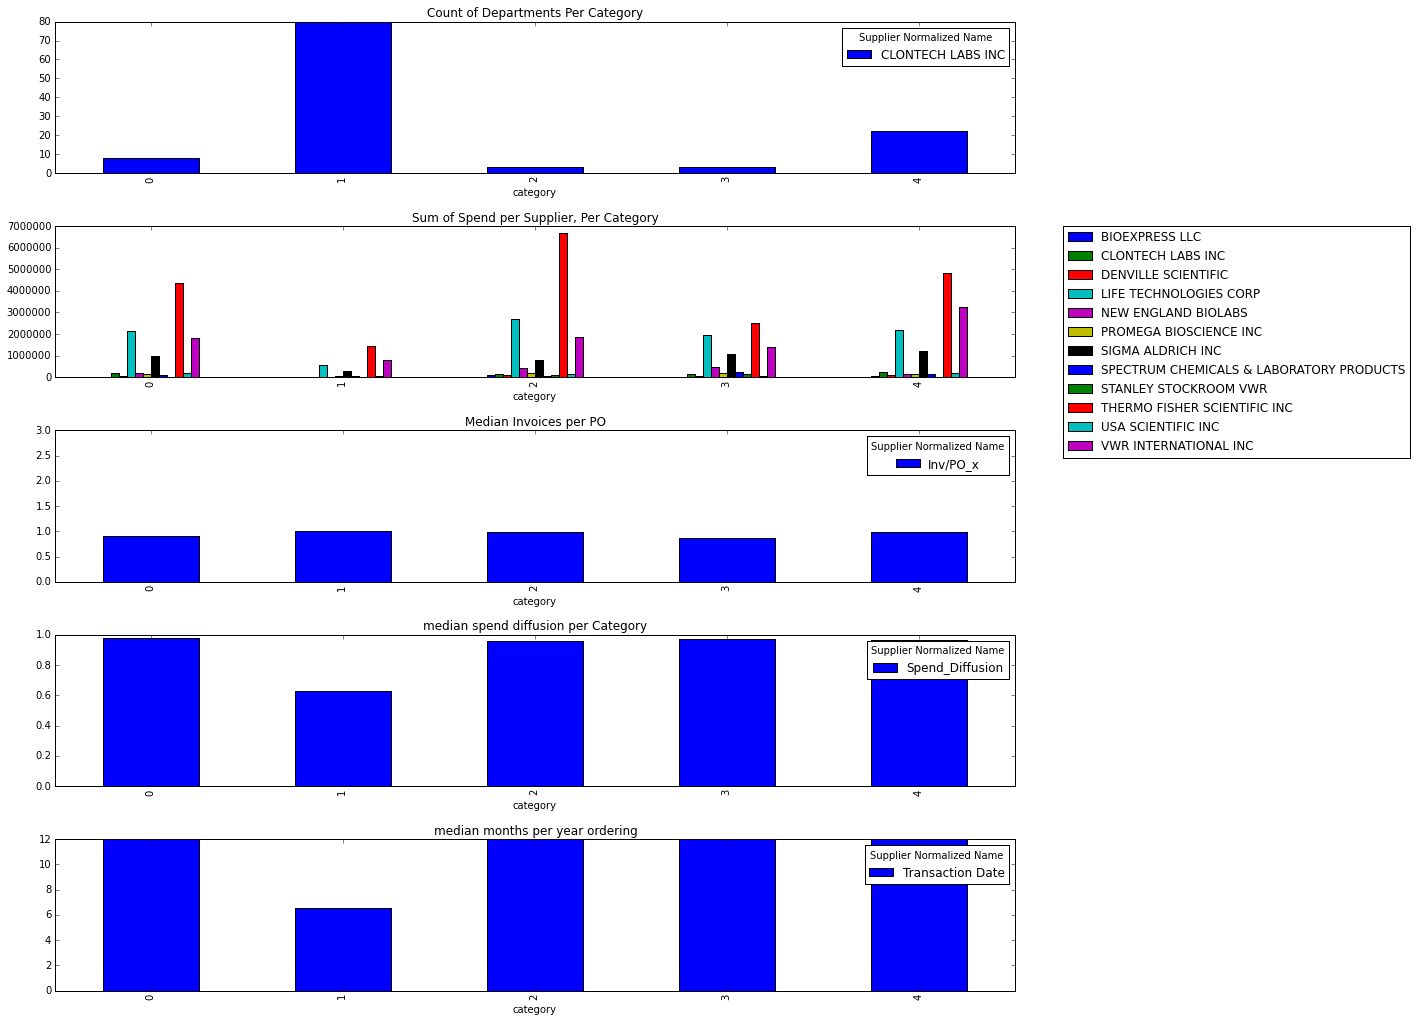

In [5]:
from sklearn.cluster import KMeans
%matplotlib inline

#Drop the category column if it exists
for col in Department_Analysis.columns:
    if col is 'category':
        Department_Analysis = Department_Analysis.drop(col,1)
        
        
#Use PCA to reduce dimensionality to 2 to check the variance explained and inspect the clusters
pca = PCA(n_components=3).fit_transform(Department_Analysis.ix[:,-NonSupplier_Features:])
pcaT = PCA(n_components=3).fit(Department_Analysis.ix[:,-NonSupplier_Features:])


#Run KMeans clustering
kmeans = KMeans(n_clusters=5)
Department_Analysis['category'] = kmeans.fit_predict(Department_Analysis.ix[:,-NonSupplier_Features:])

#Run PCA and chart the two leading Components to see what the clusters look like in 2D space
sc = plt.scatter(pca[:,0],pca[:,1], s=250, c=Department_Analysis.category, alpha=0.5, edgecolors='black')
plt.xlim(-50000,50000)
plt.legend()
plt.show()

#Group the data by supplier and plot it to see the spend per supplier/per cluster.
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(14, 14))
fig.tight_layout()
fig.subplots_adjust(hspace=.35)
ax1 = Department_Analysis.groupby('category').count()[[1]].plot(kind='bar',ax=axes[0], title='Count of Departments Per Category', label=None)
ax2 = Department_Analysis.groupby('category').sum()[[x for x in Department_Analysis.columns[0:N_Suppliers]]].plot(kind='bar',ax=axes[1], title='Sum of Spend per Supplier, Per Category').legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax3 = Department_Analysis.groupby('category').median()[['Inv/PO_x']].plot(kind='bar',ax=axes[2], title='Median Invoices per PO')
ax3.set_ylim(0,3)
ax4 = Department_Analysis.groupby('category').median()[['Spend_Diffusion']].plot(kind='bar',ax=axes[3], title='median spend diffusion per Category')
ax4.set_ylim(0,1)
ax5 = Department_Analysis.groupby('category').mean()[['Transaction Date']].plot(kind='bar',ax=axes[4], title='median months per year ordering')

,Campus,UNSPSC Level 1,UNSPSC Level 2,Tier 2 - UC Procurement Scope,Tier 3 - UC Category Group,Spend,Supplier Normalized Name,Org Level 3,Org Level 4,Org Level 5,Transaction Date,# Suppliers,# of Lines,# of POs,# of Invoices,Discount Amount
0,NaN,NaN,NaN,NaN,NaN,"1,637,736,897.57",NaN,NaN,NaN,NaN,NaN,NaN,"2,079,732",NaN,NaN,NaN
1,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"7,607,608.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/1/2014,1,11,11,11,0
2,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"36,461.85",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/10/2014,1,1,1,1,0
3,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"692,785.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/11/2014,1,1,1,1,0
4,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"57,564.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/15/2014,1,1,1,1,0
5,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"1,093,716.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/16/2014,1,1,1,1,0
6,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"404,601.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/18/2014,1,8,7,8,0
7,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"6,761,312.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/19/2014,1,6,6,6,0
8,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"24,193.55",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,1/26/2015,1,1,1,1,0
9,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"1,047,252.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,1/27/2015,1,13,11,13,0
